# KSP RocketPy
## What is this?
A handy notebook for teams to use in running basic rocketpy simulations.

Much of it is based on the [rocketpy readme](https://github.com/Projeto-Jupiter/RocketPy#readme), and the [user guide](https://docs.rocketpy.org/en/latest/notebooks/getting_started.html).

## Using KSP RocketPy
Simply import the module folder and required classes

In [1]:
from rocketpy import Environment, Rocket, SolidMotor, Flight

## Help Text
To access the documentation directly, use the inbuilt help python function.

In [2]:
help(Rocket.addFins)

Help on function addFins in module rocketpy.Rocket:

addFins(self, n, span, rootChord, tipChord, distanceToCM, radius=0, cantAngle=0, airfoil=None)
    Create a fin set, storing its parameters as part of the
    aerodynamicSurfaces list. Its parameters are the axial position
    along the rocket and its derivative of the coefficient of lift
    in respect to angle of attack.
    
    Parameters
    ----------
    n : int
        Number of fins, from 2 to infinity.
    span : int, float
        Fin span in meters.
    rootChord : int, float
        Fin root chord in meters.
    tipChord : int, float
        Fin tip chord in meters.
    distanceToCM : int, float
        Fin set position relative to rocket unloaded center of
        mass, considering positive direction from center of mass to
        nose cone. Consider the center point belonging to the top
        of the fins to calculate distance.
    radius : int, float, optional
        Reference radius to calculate lift coefficient. I

## Basic Simulation Runthrough

### Setup an environment for the simulation
This includes the date, time, weather data, launch site coordinates and launch rail length. The current pad used is [here](https://goo.gl/maps/2g3hUcQDZmZLK47N6) on the Machrihanish Range.

In [3]:
from datetime import date

today = date.today()

# The launch coords
longitude = -5.680270
latitude = 55.433159

print(f"http://maps.google.com/maps?q={latitude},{longitude}")

Env = Environment(
    railLength=4,
    latitude=latitude,
    longitude=longitude,
    elevation=40,
    date=(today.year, today.month, today.day, 12) # Launch today at 12:00
) 

http://maps.google.com/maps?q=55.433159,-5.68027


We can then create an atmospheric model for use in our flight simulation

Launch Site Details

Launch Rail Length: 4  m
Launch Date: 2022-06-19 12:00:00 UTC
Launch Site Latitude: 55.43316°
Launch Site Longitude: -5.68027°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 330421.07 W    6146261.83 N
Launch Site UTM zone: 30U
Launch Site Surface Elevation: 40.0 m


Atmospheric Model Details

Atmospheric Model Type: CustomAtmosphere
CustomAtmosphere Maximum Height: 1.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 180.00°
Surface Wind Heading: 0.00°
Surface Pressure: 1008.45 hPa
Surface Temperature: 300.00 K
Surface Air Density: 1.171 kg/m³
Surface Speed of Sound: 347.22 m/s


Atmospheric Model Plots


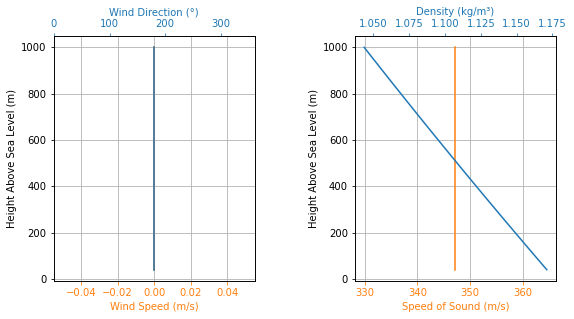

In [4]:
Env.setAtmosphericModel(
    type="CustomAtmosphere",
    pressure=None,
    temperature=300,
    wind_u=0,
    wind_v=0,
)
Env.info()

Alternativelt we can also get weather data from the [National Weather Service](https://nomads.ncep.noaa.gov/). Note that if the provided date for the environment is beyond the range of the forecasts, a `ValueError` is produced.

Launch Site Details

Launch Rail Length: 4  m
Launch Date: 2022-06-19 12:00:00 UTC
Launch Site Latitude: 55.43316°
Launch Site Longitude: -5.68027°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 330421.07 W    6146261.83 N
Launch Site UTM zone: 30U
Launch Site Surface Elevation: 39.9 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 80.492 km
Forecast Time Period: From  2022-06-18 18:00:00  to  2022-07-04 18:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 12.19 m/s
Surface Wind Direction: 329.30°
Surface Wind Heading: 149.30°
Surface Pressure: 1000.00 hPa
Surface Temperature: 284.11 K
Surface Air Density: 1.226 kg/m³
Surface Speed of Sound: 337.90 m/s


Atmospheric Model Plots


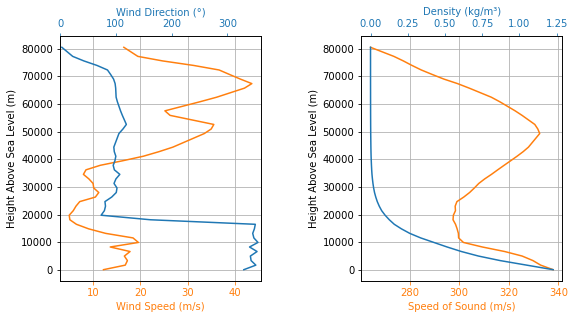

In [5]:
Env.setAtmosphericModel(type='Forecast', file='GFS')
Env.info()

### Setup a rocket motor
The motor used is the [Cesaroni M1450](https://www.thrustcurve.org/motors/Cesaroni/9955M1450-P/) as will be present on Nebula.

In [6]:
CesaroniM1450 = SolidMotor(
    thrustSource="data/motors/Cesaroni_9955M1450-P.eng",
    burnOut=6.9,
    grainNumber=5,
    interpolationMethod='linear'
)

### Setup the rocket itself
The parameters for the rocket motor, mass, drag profiles etc. (Note: this is not yet updated from Callisto)

#### Components and Centroids:

| Component                      | Centroid (m) | Weight (Kg) |
|--------------------------------|--------------|-------------|
| Nosecone                       | 1.550        | 0.089       |
| Deployment System              | 1.535        | 3.000       |
| Parachute                      | 1.245        | 0.879       |
| Parachute Section Airframe     | 1.255        | 0.100       |
| Avionics                       | 0.955        | 1.000       |
| Engine (Cesaroni 1450M, Total) | 0.440        | 8.578       |
| Engine Propellant              | 0.440        | 4.830       |
| Engine Airframe                | 0.43         | 3.600       |
| Stringer (x3)                  | 0.67         | 0.650       |
| Fins (x4)                      | 0.28         | 1.400       |
| Skirt                          | 0.078        | 0.092       |

#### Center

| State        | Center of Mass (m) | Mass (Kg) |
|--------------|--------------------|-----------|
| Rocket Full  | 0.774              | 24.888    |
| Rocket Empty | 0.871              | 20.058    |

In [7]:
NEBULA_RADIUS = 127/2000

NEBULA_UNLOADED_CM = 0.871
NEBULA_UNLOADED_MASS = 14.558

NEBULA_LOADED_CM = 0.774
NEBULA_LOADED_MASS = 19.388

NOSE_CONE_CM = 1.550
NOSE_CONE_LENGTH = 0.2 # (PLEASE UPDATE) need actual nose cone length
NOSE_CONE_TYPE = "lvhaack"

NO_FINS = 4
FINS_CM = 0.28
FINS_MASS = 1.4
FIN_ROOT_CHORD = 0.120
FIN_TIP_CHORD = 0.040
FIN_SPAN = 0.100

In [8]:
Calisto = Rocket(
    motor=CesaroniM1450,
    radius=NEBULA_RADIUS,
    mass=NEBULA_UNLOADED_MASS,
    inertiaI=6.60,   # (PLEASE UPDATE) Unloaded rocket lateral moment of inertia (without propelant) in kg m^2.
    inertiaZ=0.0351, # (PLEASE UPDATE)  Unloaded rocket axial moment of inertia (without propelant) in kg m^2
    distanceRocketNozzle=-NEBULA_UNLOADED_CM,
    distanceRocketPropellant=-NEBULA_LOADED_CM,
    powerOffDrag='data/calisto/powerOffDragCurve.csv', # (PLEASE UPDATE) mach [number, drag coefficient]
    powerOnDrag='data/calisto/powerOnDragCurve.csv'    # (PLEASE UPDATE) mach [number, drag coefficient]
)

We also add rail buttons (small wheels connected to the launch rail to guide the rocket)

In [9]:
Calisto.setRailButtons([0.2, -0.5]) # (PLEASE UPDATE) rail button positions (relatiuve to center of mass)

A nose cone, providing the distance to the center of mass and type. 
It is added to the list of aerodynamic surfaces used for simulation.

In [10]:
NoseCone = Calisto.addNose(length=NOSE_CONE_LENGTH, kind=NOSE_CONE_TYPE, distanceToCM=NOSE_CONE_CM-NEBULA_UNLOADED_CM)

Create fins, adding them to the list of aerodynamic surfaces

For nebula we have 4 equally spaced fins, of the design

In [11]:
FinSet = Calisto.addFins(4, span=FIN_SPAN, rootChord=FIN_ROOT_CHORD, tipChord=FIN_TIP_CHORD, distanceToCM=FINS_CM-NEBULA_UNLOADED_CM)

Add a tail/rocket diameter change

In [12]:
Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

Inertia Details
Rocket Dry Mass: 14.558 kg (No Propellant)
Rocket Total Mass: 38.708 kg (With Propellant)

Geometrical Parameters
Rocket Radius: 0.0635 m

Aerodynamics Stability
Initial Static Margin: -3.230 c
Final Static Margin: 0.573 c

Aerodynamics Plots


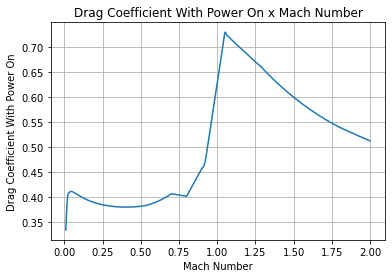

In [13]:
Calisto.info()

### Setup Recovery
Adding parachutes, including multiple stages

We can define triggers parachutes, in terms of functions using pressure and the rocket's state vector. For example we can define a trigger for the drogue and main parachute.

Pending updates from recovery, no chutes are used in this simulation.

In [14]:
"""
Trigger functions are of type trigger(p,y) -> bool

where

p: pressure in pascal
y: state vector [x, y, z, vx, vy, vz, e0, e1, e2, e3, wx, wy, wz]
"""

# Parachute deploy trigger
def deployTrigger(p, y):
    return y[5] < -50

# Parachute reef trigger
def disReefTrigger(p, y):
    return y[5] > -50 and y[5] < 0 and y[2] < 100

We can then use these functions as triggers to add parachutes to the rocket.

In [15]:
Reefed = Calisto.addParachute('Reefed',
                              CdS=1.0, # (PLEASE UPDATE) Drag coefficient times reference area for parachute
                              trigger=deployTrigger, 
                              samplingRate=105,
                              lag=1.5, # (PLEASE UPDATE) time taken from start to deployment
                              noise=(0, 8.3, 0.5))

Main = Calisto.addParachute('Disreefed',
                            CdS=10.0, # (PLEASE UPDATE) Drag coefficient times reference area for parachute
                            trigger=disReefTrigger, 
                            samplingRate=105,
                            lag=1.5, # (PLEASE UPDATE) time taken to reef
                            noise=(0, 8.3, 0.5))

## Run Simulation
Instantiating the `Flight` class runs the simulation, and generates data required for analysis.

This may be caused by more than when parachute being triggered simultaneously.
Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 39.87 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Launch Rail Orientation

Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: -10.48 m/s
Lateral Surface Wind Speed: -6.22 m/s


 Rail Departure State

Rail Departure Time: 0.423 s
Rail Departure Velocity: 16.720 m/s
Rail Departure Static Margin: -3.112 c
Rail Departure Angle of Attack: 34.582°
Rail Departure Thrust-Weight Ratio: 5.746
Rail Departure Reynolds Number: 1.885e+05


BurnOut State

BurnOut time: 6.870 s
Altitude at burnOut: 372.411 m (AGL)
Rocket velocity at burnOut: 32.994 m/s
Freestream velocity at burnOut: 23.887 m/s
M

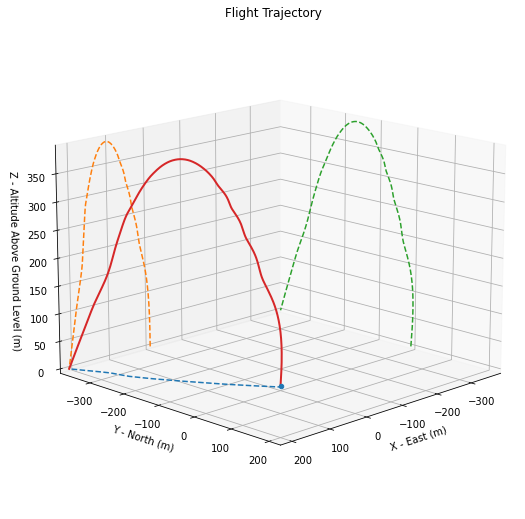



Trajectory Kinematic Plots



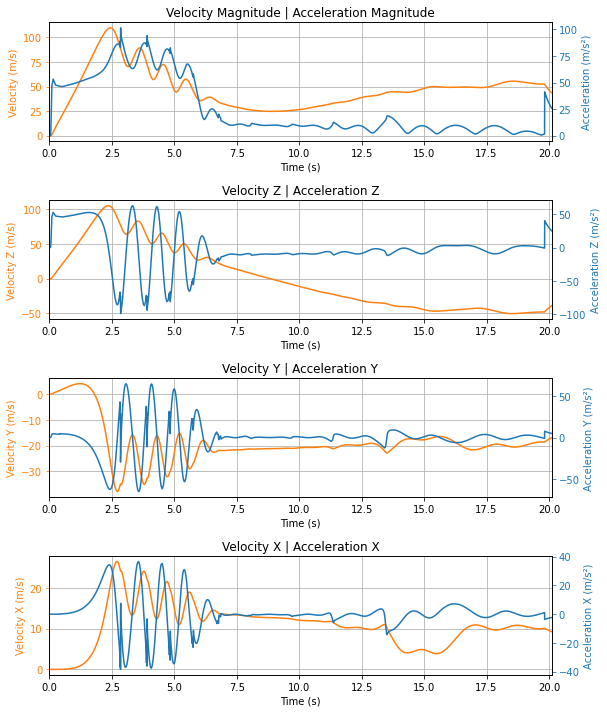



Angular Position Plots



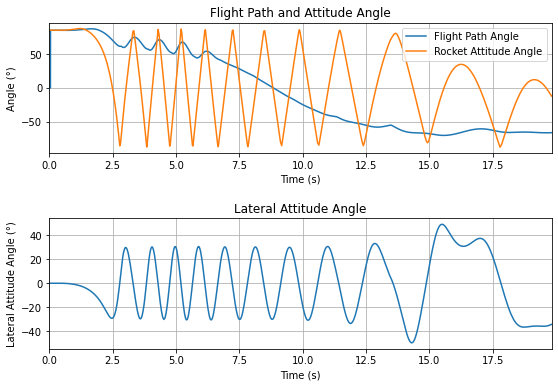



Path, Attitude and Lateral Attitude Angle plots



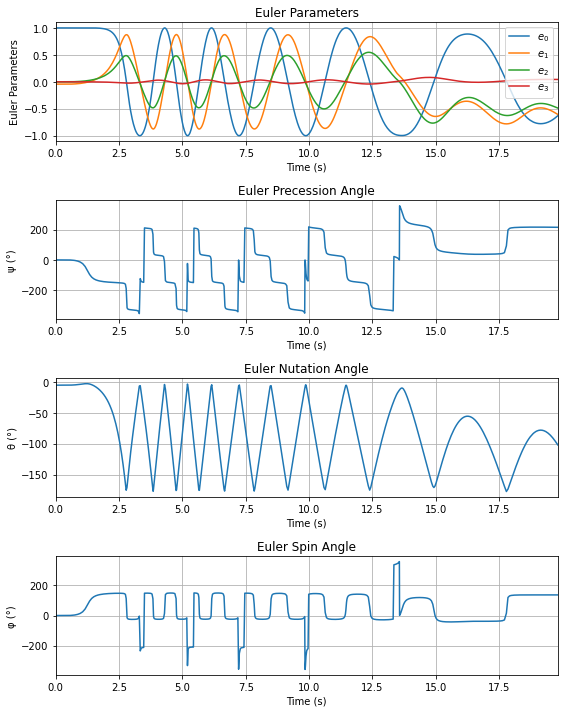



Trajectory Angular Velocity and Acceleration Plots



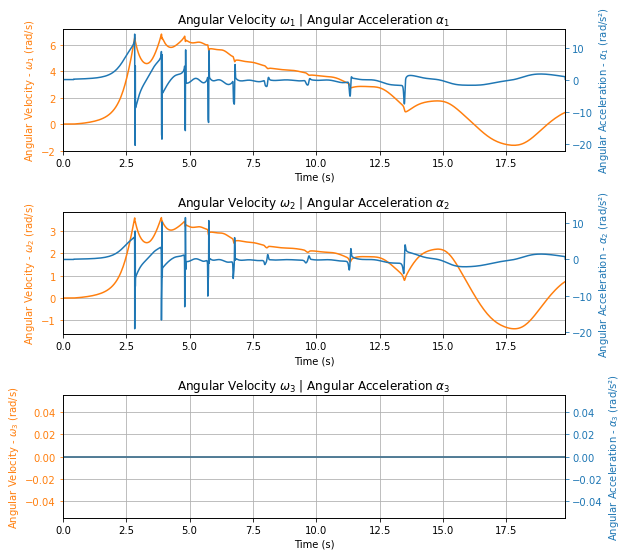



Trajectory Force Plots



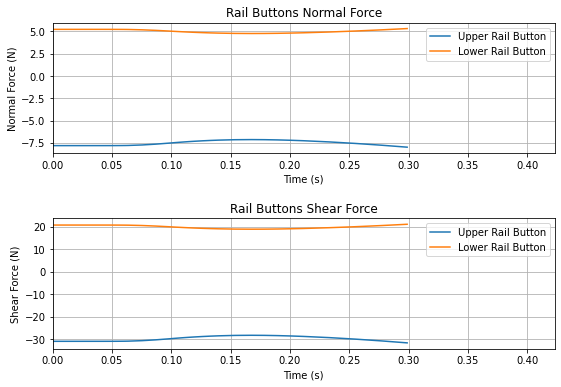

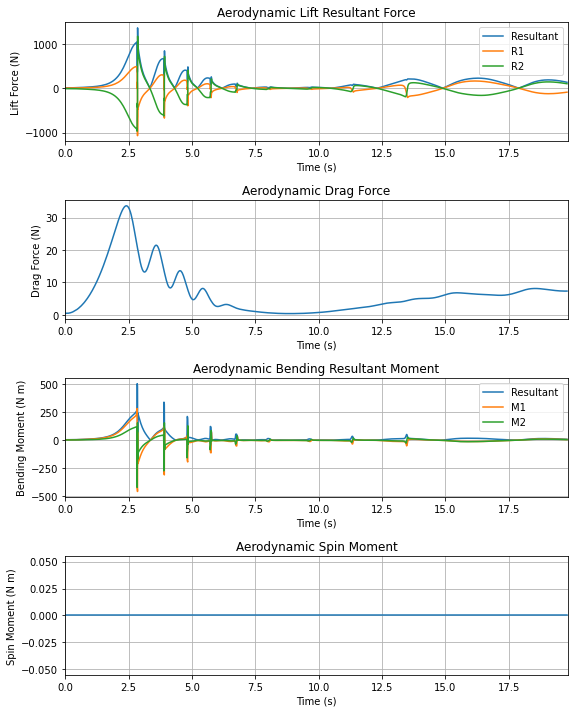



Trajectory Energy Plots



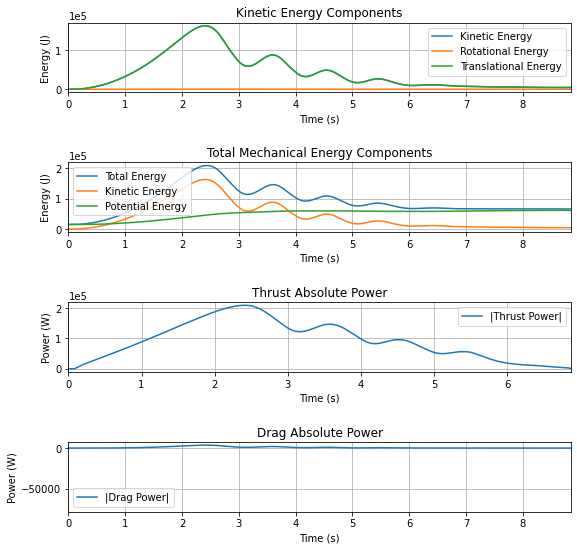



Trajectory Fluid Mechanics Plots



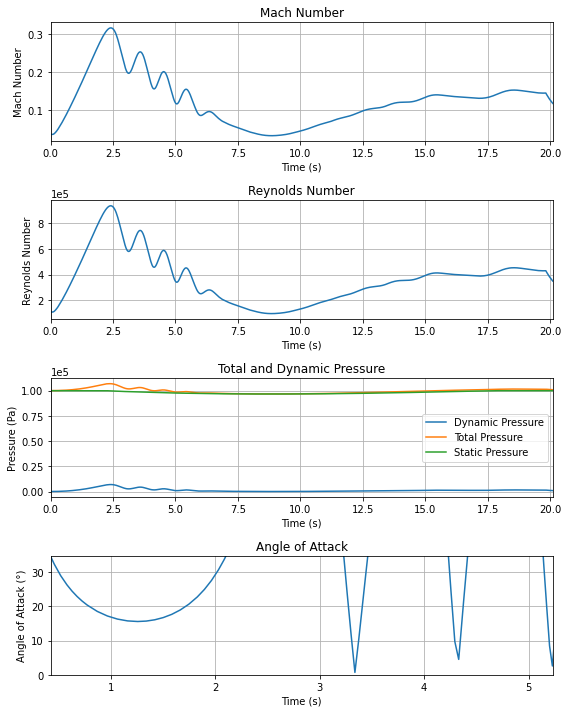



Trajectory Stability and Control Plots



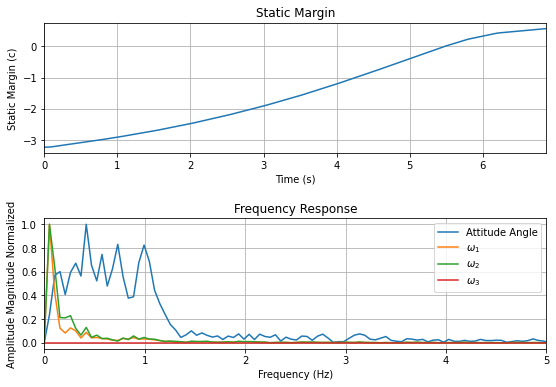

In [16]:
TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0)
TestFlight.allInfo()

In [17]:
finallongitude = longitude + TestFlight.xImpact * 0.00001
finallatitude = latitude + TestFlight.yImpact * 0.00001

print(f"http://maps.google.com/maps/dir/{finallatitude},{finallongitude}/{latitude},{longitude}")

http://maps.google.com/maps/dir/55.429391392735006,-5.678095803713278/55.433159,-5.68027
